In [1]:
# --- Configuration ---
DATA_ROOT      = "data/npy/IDRiD_Seg"         # folder with imgs_test/, gts_test/, meta_test.json
META_JSON      = f"{DATA_ROOT}/meta_test.json" # set to your test meta (from pre_idrid.py)
OUT_DIR        = "runs/medsam_idrid_eval"      # where results & figures are written

BASELINE_CKPT  = "work_dir/MedSAM/medsam_vit_b.pth"
FINETUNED_CKPT = "runs/medsam_idrid_ft/medsam_idrid_best_lrNew.pth"  # update if different

DEVICE_DECODER = "cuda"   # GPU for prompt+decoder
FIGS_PER_STRAT = 10       # save at most 10 figures per prompt strategy

# Use the same training-time prompt styles
PROMPT_STRATS = ["box","points3", "points1neg4", "box+point1"]

# --- Imports & setup ---
import os, gc, json, random
from pathlib import Path
import numpy as np
import torch
import torch.nn.functional as F
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from skimage import measure
from scipy.ndimage import distance_transform_edt

from segment_anything import sam_model_registry

# CUDA memory behavior
os.environ.setdefault("PYTORCH_CUDA_ALLOC_CONF", "expandable_segments:True")
torch.backends.cuda.matmul.allow_tf32 = True

# Reproducibility
random.seed(0); np.random.seed(0); torch.manual_seed(0)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(0)

def clear_cuda():
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.ipc_collect()

Path(OUT_DIR).mkdir(parents=True, exist_ok=True)
Path(f"{OUT_DIR}/figs").mkdir(parents=True, exist_ok=True)
Path(f"{OUT_DIR}/preds_baseline").mkdir(parents=True, exist_ok=True)
Path(f"{OUT_DIR}/preds_finetuned").mkdir(parents=True, exist_ok=True)

# --- Load test items ---
with open(META_JSON, "r") as f:
    items = json.load(f)
assert len(items) > 0, "No items found. Check META_JSON path."
print(f"Loaded {len(items)} test items from {META_JSON}")
print("Example item:", items[0])


Loaded 1550 test items from data/npy/IDRiD_Seg/meta_test.json
Example item: {'pid': 'IDRiD_55', 'class': 'MA', 'instance': 0, 'img': 'data/npy/IDRiD_Seg/imgs_test/IDRiD_55-MA-000.npy', 'gt': 'data/npy/IDRiD_Seg/gts_test/IDRiD_55-MA-000.npy', 'area': 81}


In [2]:
def compute_metrics(gt, pred):
    # both uint8 {0,1}
    gt = gt.astype(np.uint8)
    pred = pred.astype(np.uint8)
    tp = np.logical_and(gt==1, pred==1).sum()
    fp = np.logical_and(gt==0, pred==1).sum()
    fn = np.logical_and(gt==1, pred==0).sum()
    tn = np.logical_and(gt==0, pred==0).sum()

    dice = (2*tp) / max(1, 2*tp + fp + fn)
    iou  = tp / max(1, tp + fp + fn)
    prec = tp / max(1, tp + fp)
    rec  = tp / max(1, tp + fn)
    return dict(dice=float(dice), iou=float(iou), precision=float(prec), recall=float(rec),
                tp=int(tp), fp=int(fp), fn=int(fn), tn=int(tn))


In [3]:
import torch

def _to_2d_mask(mask_t: torch.Tensor, thresh: float = 0.5) -> torch.Tensor:
    # Accept (H,W), (1,H,W), (B,1,H,W), (C,H,W); collapse → (H,W) boolean
    if mask_t.dtype != torch.bool:
        mask_t = mask_t > thresh
    m = mask_t.squeeze()
    while m.ndim > 2:
        m = m.any(dim=0)
    if m.ndim != 2:
        raise ValueError(f"Expected 2D mask after squeeze/merge, got {tuple(m.shape)}")
    return m

def bbox_from_mask(mask_t: torch.Tensor, thresh: float = 0.5):
    m = _to_2d_mask(mask_t, thresh=thresh)
    ys, xs = torch.nonzero(m, as_tuple=True)
    if ys.numel() == 0:
        return None
    x0 = int(xs.min().item()); y0 = int(ys.min().item())
    x1 = int(xs.max().item()); y1 = int(ys.max().item())
    return [x0, y0, x1, y1]

def sample_pos(mask_t: torch.Tensor, k: int = 1, thresh: float = 0.5):
    m = _to_2d_mask(mask_t, thresh=thresh)
    ys, xs = torch.nonzero(m, as_tuple=True)
    n = xs.numel()
    if n == 0:
        return []
    k = min(k, n)
    idx = torch.randperm(n)[:k]
    return [[int(xs[j]), int(ys[j])] for j in idx]

def sample_neg(mask_t: torch.Tensor, k: int = 4, thresh: float = 0.5):
    m = _to_2d_mask(mask_t, thresh=thresh)
    bg = (~m).cpu().numpy().astype(np.uint8)
    if int(bg.sum()) == 0 or k <= 0:
        return []
    dist = distance_transform_edt(bg)
    flat = dist.ravel()
    k = min(k, int(bg.sum()))
    idxs = np.argpartition(flat, -k)[-k:]
    ys, xs = np.unravel_index(idxs, dist.shape)
    order = np.argsort(dist[ys, xs])[::-1]
    ys, xs = ys[order], xs[order]
    return [[int(x), int(y)] for y, x in zip(ys, xs)]

def make_prompt_from_gt(gt_mask_uint8: np.ndarray, strat: str):
    """
    gt_mask_uint8: (H,W) {0,1}; returns (box_np or None, points_tuple or None)
    points_tuple = (coords[1,N,2], labels[1,N]); coords are (x,y) in 1024-scale.
    """
    gt_t = torch.from_numpy(gt_mask_uint8)[None, ...].float()  # (1,H,W)
    box_np = None; points_tuple = None

    if strat in ["box", "box+point1"]:
        b = bbox_from_mask(gt_t)
        if b is not None:
            box_np = np.array([b], dtype=np.float32)  # (1,4) x0,y0,x1,y1

    if strat in ["points3", "points1neg4", "box+point1"]:
        kpos = {"points1":1, "points3":3, "points5":5, "points1neg4":1, "box+point1":1}[strat]
        pos = sample_pos(gt_t, k=kpos)
        neg = sample_neg(gt_t, k=4 if strat=="points1neg4" else 0)
        all_pts, labs = [], []
        if len(pos) > 0: all_pts.extend(pos); labs.extend([1]*len(pos))
        if len(neg) > 0: all_pts.extend(neg); labs.extend([0]*len(neg))
        if len(all_pts) > 0:
            coords = np.array(all_pts, dtype=np.float32)[None, ...]
            labels = np.array(labs,    dtype=np.int64  )[None, ...]
            points_tuple = (coords, labels)
    return box_np, points_tuple


In [4]:
# ==== FAST PATH: GPU encoder with AMP, fallback to CPU on OOM ====
import gc, re
import numpy as np
import torch
import torch.nn.functional as F
from segment_anything import sam_model_registry

# configure AMP dtype automatically
def _amp_dtype():
    # prefer bf16 if supported; otherwise fp16
    if torch.cuda.is_available() and torch.cuda.is_bf16_supported():
        return torch.bfloat16
    return torch.float16

AMP_DTYPE = _amp_dtype()

def clear_cuda():
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.ipc_collect()

@torch.inference_mode()
def load_sam_baseline(ckpt_base, device="cuda"):
    sam = sam_model_registry["vit_b"](checkpoint=ckpt_base)
    # keep all modules on device for speed
    sam.to(device)
    sam.eval()
    return sam

@torch.inference_mode()
def load_sam_finetuned(ckpt_base, ckpt_finetuned, device="cuda"):
    sam = sam_model_registry["vit_b"](checkpoint=ckpt_base)
    state = torch.load(ckpt_finetuned, map_location="cpu")
    sam.load_state_dict(state, strict=False)
    sam.to(device)
    sam.eval()
    return sam

def _is_oom(e: RuntimeError) -> bool:
    msg = str(e).lower()
    return "out of memory" in msg or "cublas error" in msg or "cuda error" in msg

@torch.inference_mode()
def encode_image_auto(sam, img_1024: np.ndarray, device="cuda", use_amp=True):
    """
    Try encoding on GPU with AMP; if OOM, fallback to CPU. Returns CPU tensor (1,256,64,64).
    """
    # try CUDA first
    if torch.cuda.is_available() and device == "cuda":
        try:
            img_t = torch.from_numpy(img_1024).permute(2,0,1).unsqueeze(0).to("cuda", non_blocking=True)
            with torch.cuda.amp.autocast(enabled=use_amp, dtype=AMP_DTYPE):
                embed = sam.image_encoder(img_t)  # encoder is already on CUDA
            embed_cpu = embed.detach().to("cpu")
            del img_t, embed
            clear_cuda()
            return embed_cpu
        except RuntimeError as e:
            if _is_oom(e):
                # fallback to CPU
                print('Falling back on cpu')
                del img_t
                clear_cuda()
            else:
                raise

    # CPU fallback
    img_t = torch.from_numpy(img_1024).permute(2,0,1).unsqueeze(0)  # CPU
    embed_cpu = sam.image_encoder.to("cpu")(img_t).cpu()
    del img_t
    gc.collect()
    return embed_cpu

@torch.inference_mode()
def predict_with_cached_embed(
    sam, embed_cpu, box_np=None, points_tuple=None, device="cuda", thresh=0.5, use_amp=True
):
    """
    Takes CPU embedding, runs prompt+decoder on GPU with AMP, returns (mask, prob).
    """
    dev = torch.device(device if torch.cuda.is_available() else "cpu")
    embed = embed_cpu.to(dev, non_blocking=True)

    boxes_t = None; points_t = None
    if box_np is not None:
        b = np.array(box_np, dtype=np.float32).reshape(1,4)
        boxes_t = torch.as_tensor(b, dtype=torch.float32, device=dev)[:, None, :]
    if points_tuple is not None:
        coords_np, labels_np = points_tuple
        coords_t = torch.as_tensor(coords_np, dtype=torch.float32, device=dev)
        labels_t = torch.as_tensor(labels_np, dtype=torch.int64,   device=dev)
        points_t = (coords_t, labels_t)

    with torch.cuda.amp.autocast(enabled=(use_amp and dev.type=="cuda"), dtype=AMP_DTYPE):
        sparse, dense = sam.prompt_encoder(points=points_t, boxes=boxes_t, masks=None)
        logits_low, _ = sam.mask_decoder(
            image_embeddings=embed,
            image_pe=sam.prompt_encoder.get_dense_pe(),
            sparse_prompt_embeddings=sparse,
            dense_prompt_embeddings=dense,
            multimask_output=False,
        )
        prob = torch.sigmoid(logits_low)  # (1,1,256,256)

    prob = F.interpolate(prob.float(), size=(1024,1024), mode="bilinear", align_corners=False)
    prob_np = prob.squeeze().detach().cpu().numpy()
    mask_np = (prob_np > float(thresh)).astype(np.uint8)

    del embed, sparse, dense, logits_low, prob
    clear_cuda()
    return mask_np, prob_np


In [5]:
def _draw_contour(ax, mask, color="yellow", lw=2.0):
    if mask is None or mask.sum()==0:
        return
    for c in measure.find_contours(mask.astype(float), 0.5):
        ax.plot(c[:,1], c[:,0], color=color, linewidth=lw)

def _draw_box(ax, box, color="blue", lw=2.0):
    if box is None: return
    x0,y0,x1,y1 = box
    ax.add_patch(plt.Rectangle((x0,y0), x1-x0, y1-y0, fill=False, edgecolor=color, linewidth=lw))

def _draw_points(ax, points_tuple):
    if points_tuple is None: return
    coords, labels = points_tuple
    coords = coords[0]; labels = labels[0]
    for (x,y), lab in zip(coords, labels):
        if lab==1:
            ax.plot([x],[y], marker='o', markersize=6, markerfacecolor='none', markeredgecolor='lime', markeredgewidth=2)
        else:
            ax.plot([x],[y], marker='x', markersize=7, color='red', mew=2)

def _compute_zoom_box(gt_mask, fallback=(256,256,768,768)):
    if gt_mask.sum() == 0: return fallback
    ys, xs = np.where(gt_mask > 0)
    x0, y0 = max(0, xs.min()-40), max(0, ys.min()-40)
    x1, y1 = min(1023, xs.max()+40), min(1023, ys.max()+40)
    return [x0,y0,x1,y1]

def plot_triptych(img, gt, pred_base, pred_ft, box_np, points_tuple, out_path, dice_b=None, dice_f=None):
    Path(out_path).parent.mkdir(parents=True, exist_ok=True)
    fig, axes = plt.subplots(1, 3, figsize=(15,5))
    ax = axes[0]; ax.imshow(img); _draw_contour(ax, gt, 'yellow', 2); ax.set_title("a) Image + GT"); ax.axis('off')
    ax = axes[1]; ax.imshow(img); _draw_contour(ax, pred_base, 'cyan',   2); _draw_box(ax, box_np[0] if box_np is not None else None); _draw_points(ax, points_tuple)
    ax.set_title(f"b) Baseline (Dice={dice_b:.3f})" if isinstance(dice_b,(float,int)) else "b) Baseline"); ax.axis('off')
    ax = axes[2]; ax.imshow(img); _draw_contour(ax, pred_ft,   'magenta',2); _draw_box(ax, box_np[0] if box_np is not None else None); _draw_points(ax, points_tuple)
    ax.set_title(f"c) Finetuned (Dice={dice_f:.3f})" if isinstance(dice_f,(float,int)) else "c) Finetuned"); ax.axis('off')
    plt.show()
    plt.tight_layout(); plt.savefig(out_path, dpi=150); plt.close(fig)

def show_triptych_zoom(img, gt, pred_base, pred_ft, box_np, points_tuple, out_path, dice_b=None, dice_f=None):
    # same signature, zoomed
    x0,y0,x1,y1 = _compute_zoom_box(gt)
    img_c = img[y0:y1, x0:x1]; gt_c = gt[y0:y1, x0:x1]; pb_c = pred_base[y0:y1, x0:x1]; pf_c = pred_ft[y0:y1, x0:x1]
    adj_box = None
    if box_np is not None:
        bx = box_np[0].copy()
        adj_box = [max(0,bx[0]-x0), max(0,bx[1]-y0), max(0,bx[2]-x0), max(0,bx[3]-y0)]
    adj_pts = None
    if points_tuple is not None:
        coords, labels = points_tuple
        coords = coords.copy()
        coords[...,0] -= x0; coords[...,1] -= y0
        adj_pts = (coords, labels)

    Path(out_path).parent.mkdir(parents=True, exist_ok=True)
    fig, axes = plt.subplots(1, 3, figsize=(15,5))
    ax = axes[0]; ax.imshow(img_c); _draw_contour(ax, gt_c, 'yellow', 2); ax.set_title("a) Image + GT (zoom)"); ax.axis('off')
    ax = axes[1]; ax.imshow(img_c); _draw_contour(ax, pb_c, 'cyan',   2); _draw_box(ax, adj_box); _draw_points(ax, adj_pts)
    ax.set_title(f"b) Baseline (Dice={dice_b:.3f})" if isinstance(dice_b,(float,int)) else "b) Baseline"); ax.axis('off')
    ax = axes[2]; ax.imshow(img_c); _draw_contour(ax, pf_c,   'magenta',2); _draw_box(ax, adj_box); _draw_points(ax, adj_pts)
    ax.set_title(f"c) Finetuned (Dice={dice_f:.3f})" if isinstance(dice_f,(float,int)) else "c) Finetuned"); ax.axis('off')
    plt.show()
    plt.tight_layout(); plt.savefig(out_path, dpi=150); plt.close(fig)


In [6]:
baseline = load_sam_baseline(BASELINE_CKPT, device=DEVICE_DECODER)

print("Baseline model loaded (encoder on CUDA with AMP; auto-fallback to CPU).")

pred_dir_b = Path(OUT_DIR) / "preds_baseline"
pred_dir_b.mkdir(parents=True, exist_ok=True)

results = {}   # {(case_id, strat): metrics}

bar = tqdm(items, desc="Baseline pass (GPU encode w/ AMP → CPU fallback)", leave=False)
for m in bar:
    img = np.load(m["img"]).astype(np.float32)          # (1024,1024,3) in [0,1]
    gt  = (np.load(m["gt"]).astype(np.uint8) > 0).astype(np.uint8)
    case_id = Path(m["img"]).stem

    embed_cpu = encode_image_auto(baseline, img, device=DEVICE_DECODER, use_amp=True)

    for strat in PROMPT_STRATS:
        #print(f"Predicting for {strat}")

        box_np, points_tuple = make_prompt_from_gt(gt, strat)

        pred_b, _ = predict_with_cached_embed(
            baseline, embed_cpu, box_np, points_tuple,
            device=DEVICE_DECODER, thresh=0.5, use_amp=True
        )

        out_np = pred_dir_b / strat / f"{case_id}.npy"
        out_np.parent.mkdir(parents=True, exist_ok=True)
        np.save(out_np, pred_b)

        metrics_b = compute_metrics(gt, pred_b)

        key = (case_id, strat)
        results.setdefault(key, {})
        results[key].update({
            "img": m["img"], "gt": m["gt"], "prompt_strat": strat,
            "dice_baseline": metrics_b["dice"],
            "iou_baseline": metrics_b["iou"],
            "precision_baseline": metrics_b["precision"],
            "recall_baseline": metrics_b["recall"],
        })

    del embed_cpu, img, gt
    clear_cuda()

del baseline
clear_cuda()
print("Baseline pass complete and freed.")


/home/nidhi/Ila/MEDSAM/segment_anything/build_sam.py:144: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f, map_location=torch.device('cpu'))


Baseline model loaded (encoder on CUDA with AMP; auto-fallback to CPU).


Baseline pass (GPU encode w/ AMP → CPU fallback):   0%|          | 0/1550 [00:00<?, ?it/s]

/tmp/ipykernel_2960780/4238675727.py:53: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp, dtype=AMP_DTYPE):
/tmp/ipykernel_2960780/4238675727.py:95: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(use_amp and dev.type=="cuda"), dtype=AMP_DTYPE):


Baseline pass complete and freed.


Finetuned model loaded (encoder on CUDA with AMP; auto-fallback to CPU).


/tmp/ipykernel_2960780/4238675727.py:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(ckpt_finetuned, map_location="cpu")


Finetuned pass (GPU encode w/ AMP → CPU fallback):   0%|          | 0/1550 [00:00<?, ?it/s]

/tmp/ipykernel_2960780/4238675727.py:53: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=use_amp, dtype=AMP_DTYPE):
/tmp/ipykernel_2960780/4238675727.py:95: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(use_amp and dev.type=="cuda"), dtype=AMP_DTYPE):


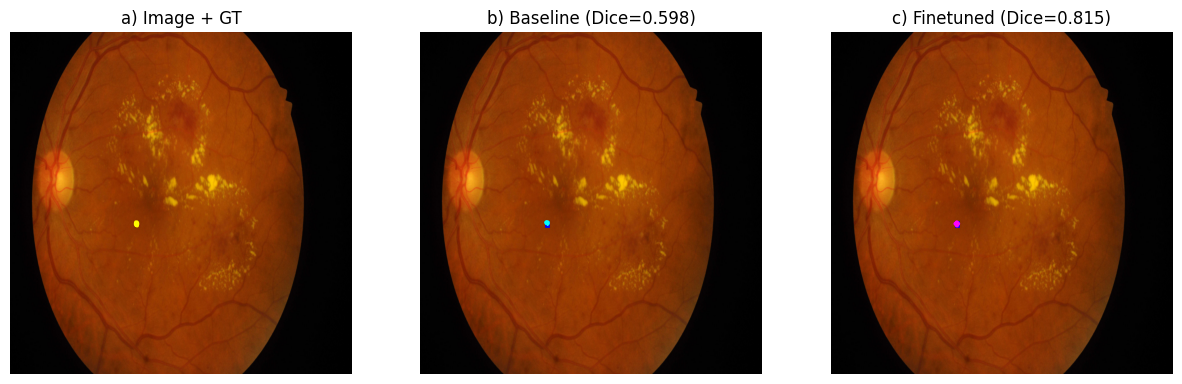

<Figure size 640x480 with 0 Axes>

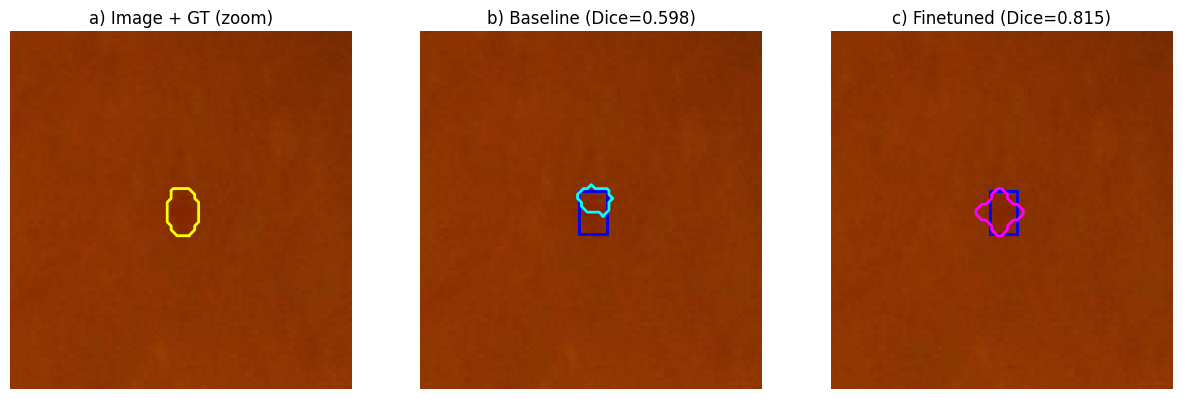

<Figure size 640x480 with 0 Axes>

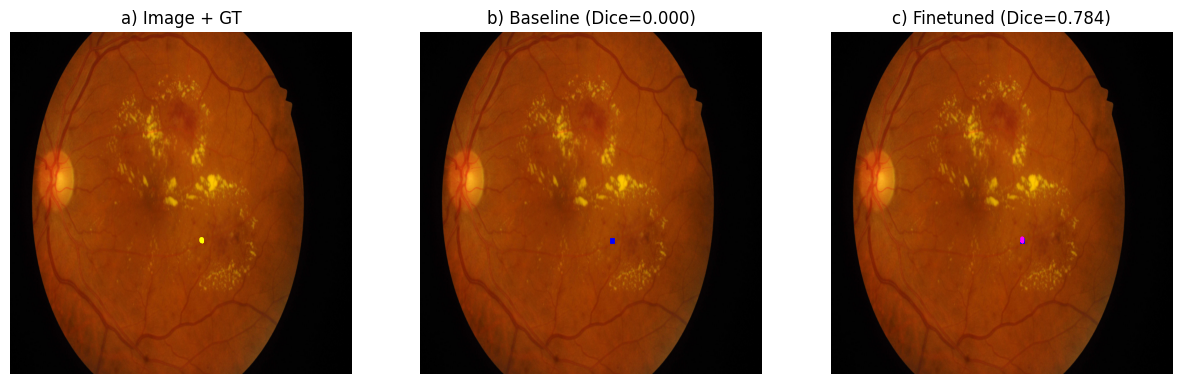

<Figure size 640x480 with 0 Axes>

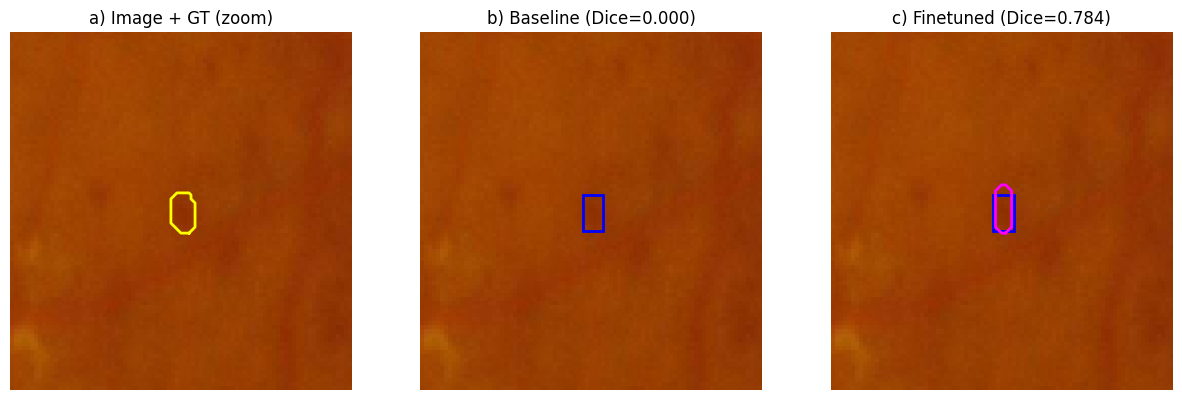

<Figure size 640x480 with 0 Axes>

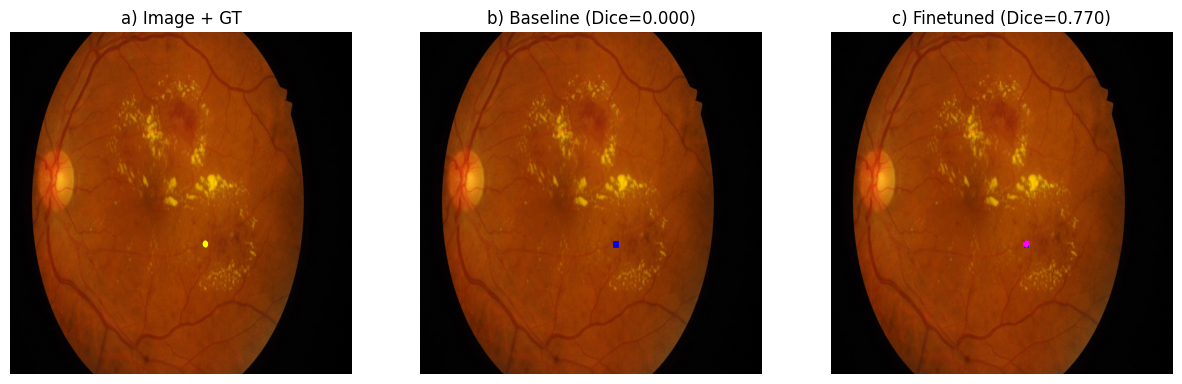

<Figure size 640x480 with 0 Axes>

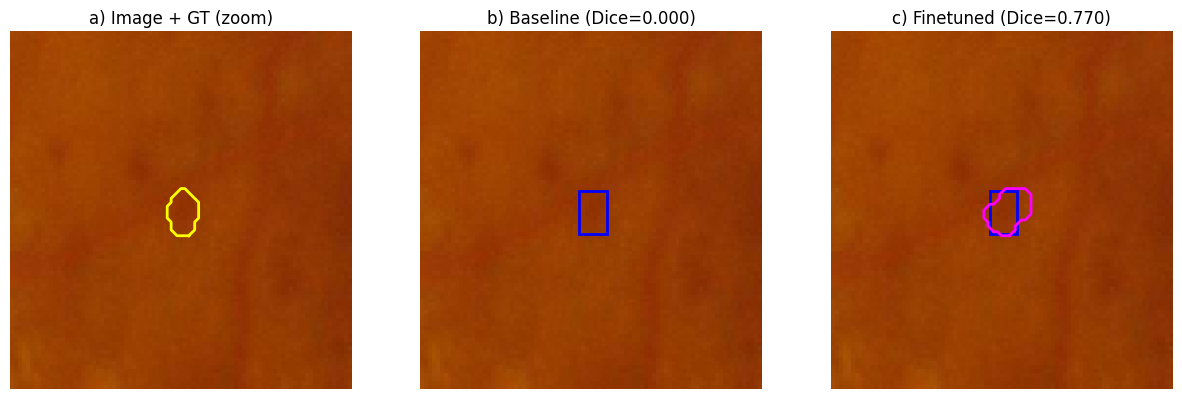

<Figure size 640x480 with 0 Axes>

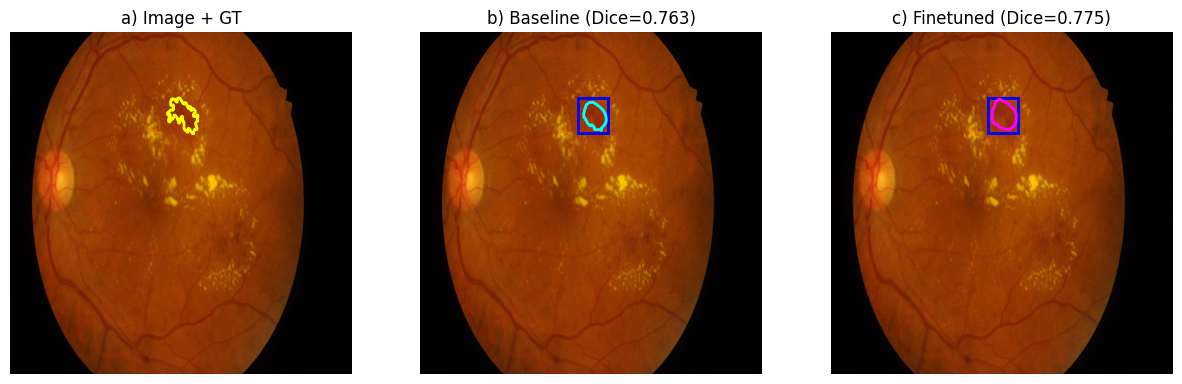

<Figure size 640x480 with 0 Axes>

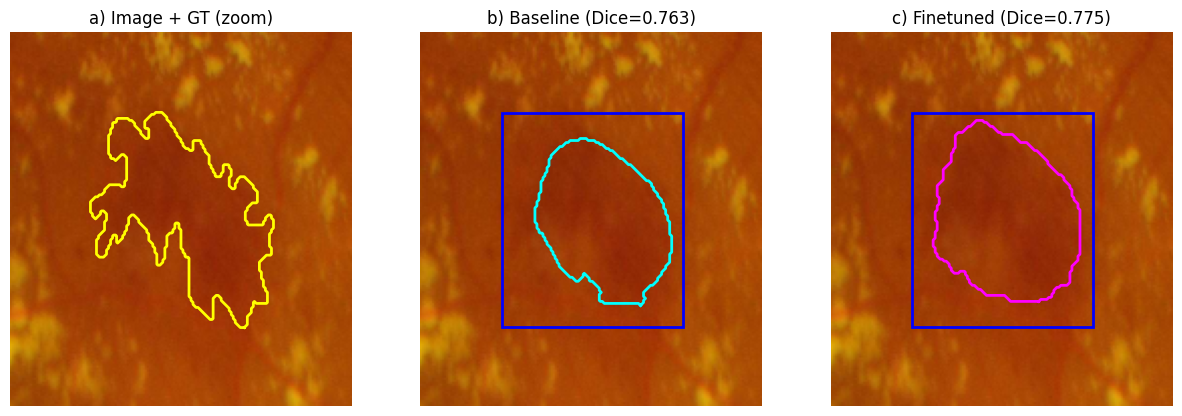

<Figure size 640x480 with 0 Axes>

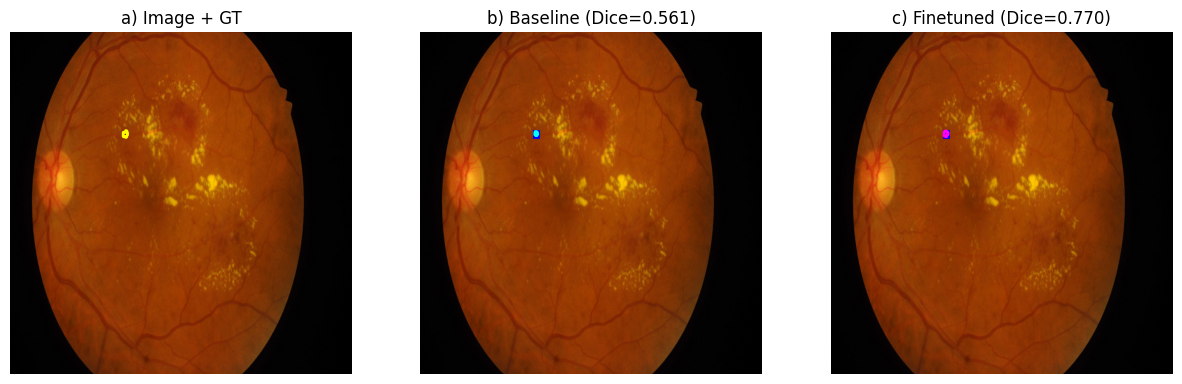

<Figure size 640x480 with 0 Axes>

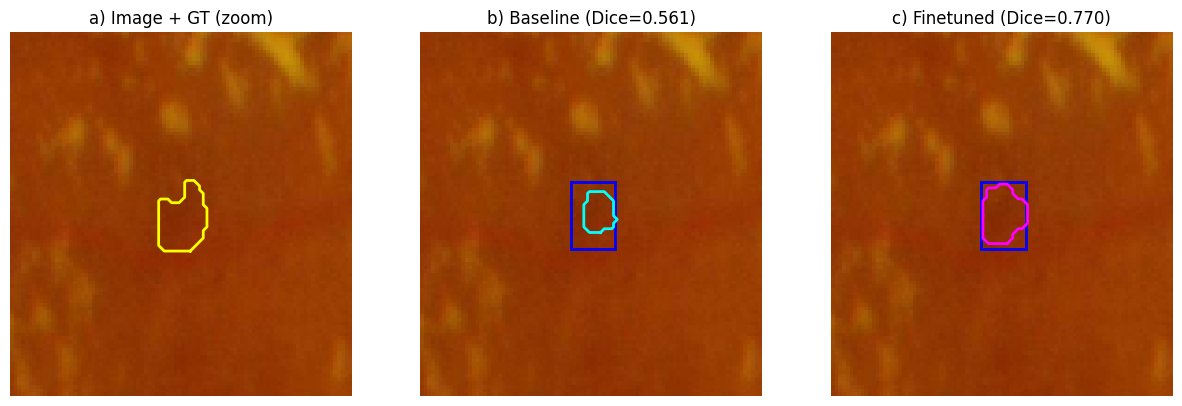

<Figure size 640x480 with 0 Axes>

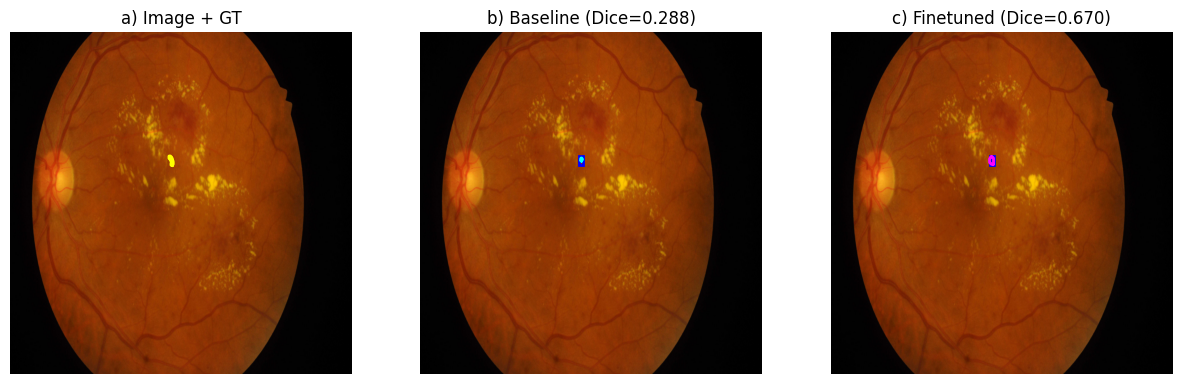

<Figure size 640x480 with 0 Axes>

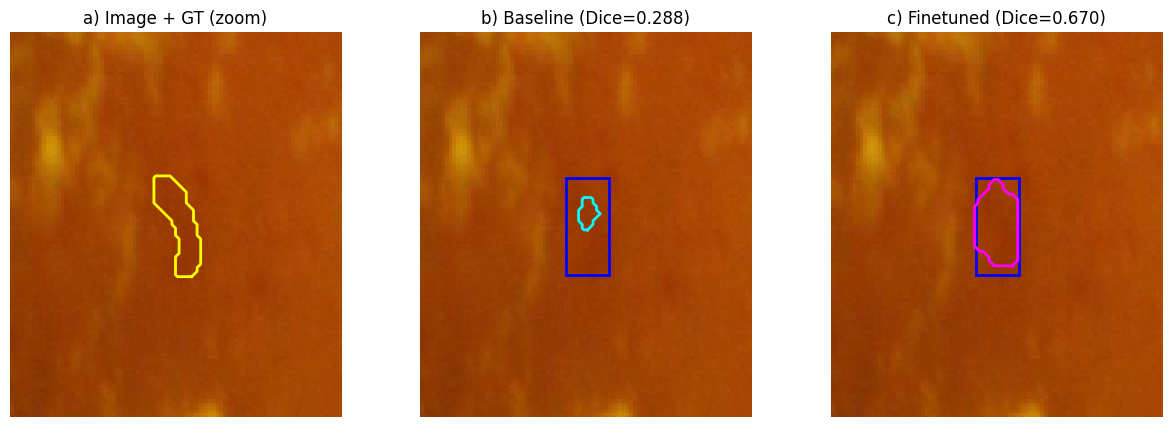

<Figure size 640x480 with 0 Axes>

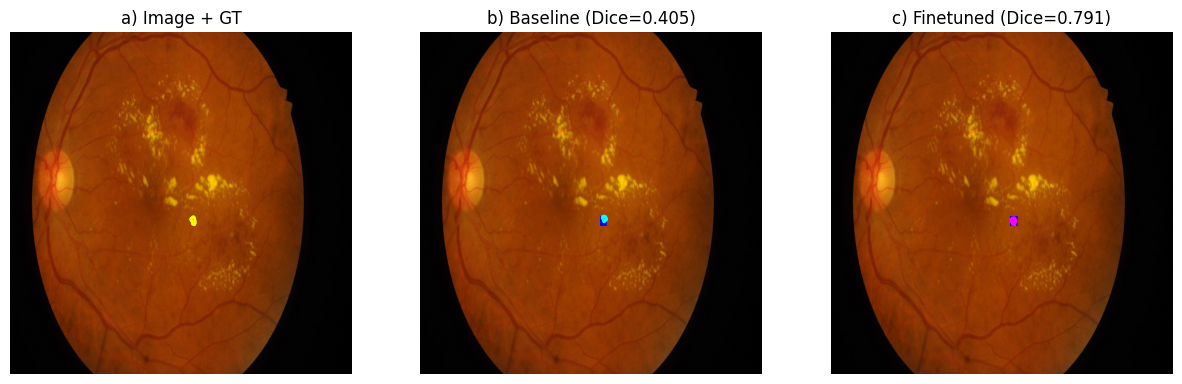

<Figure size 640x480 with 0 Axes>

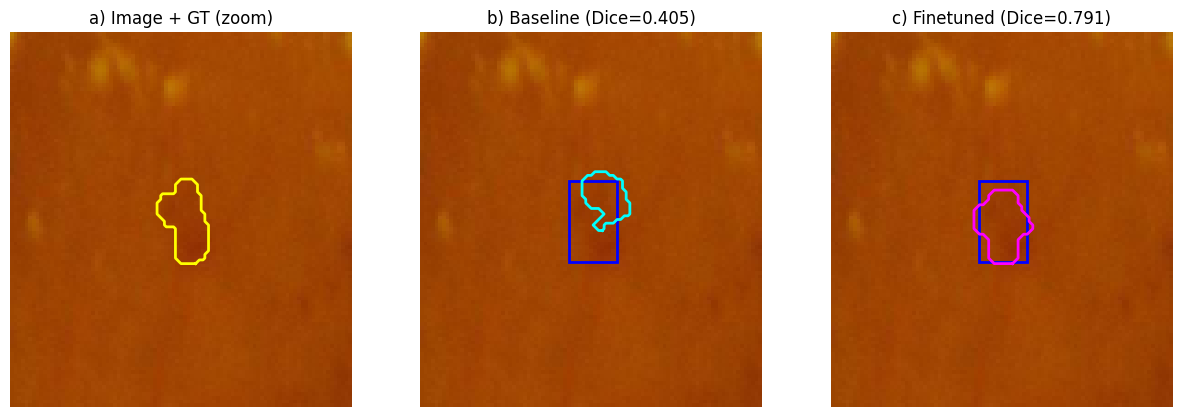

<Figure size 640x480 with 0 Axes>

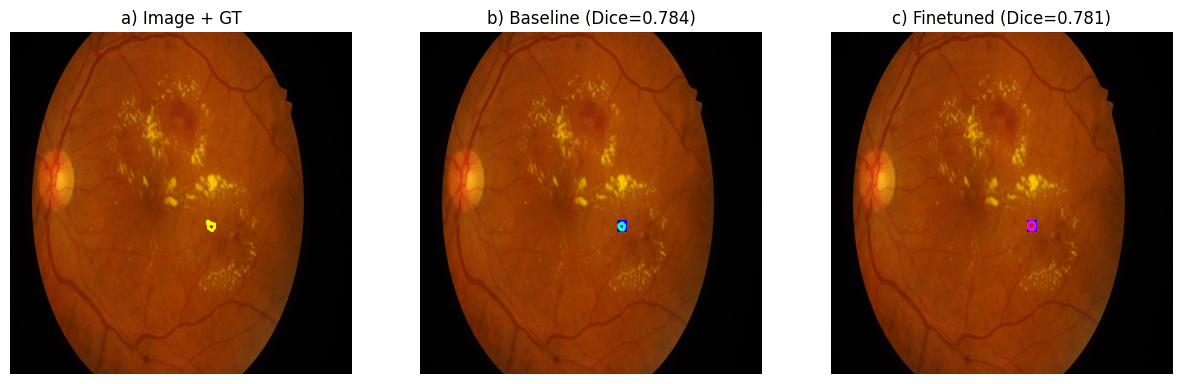

<Figure size 640x480 with 0 Axes>

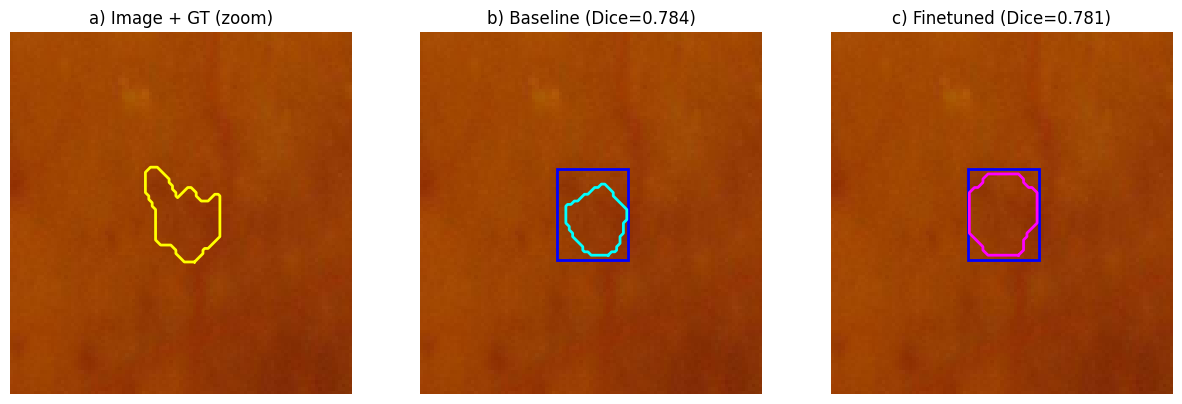

<Figure size 640x480 with 0 Axes>

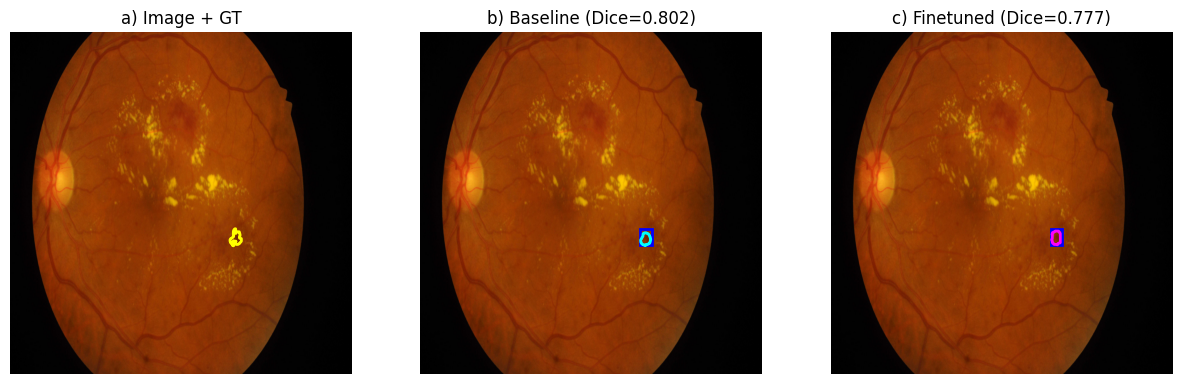

<Figure size 640x480 with 0 Axes>

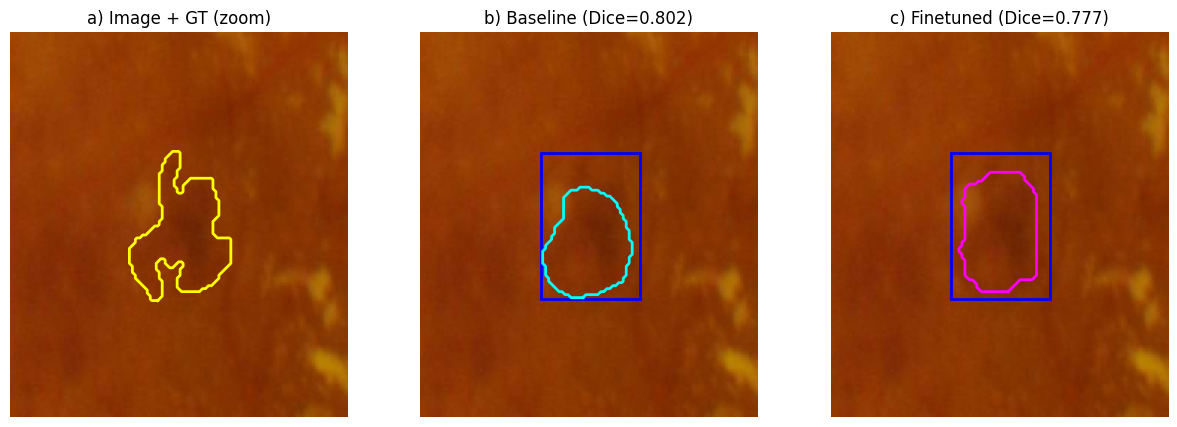

<Figure size 640x480 with 0 Axes>

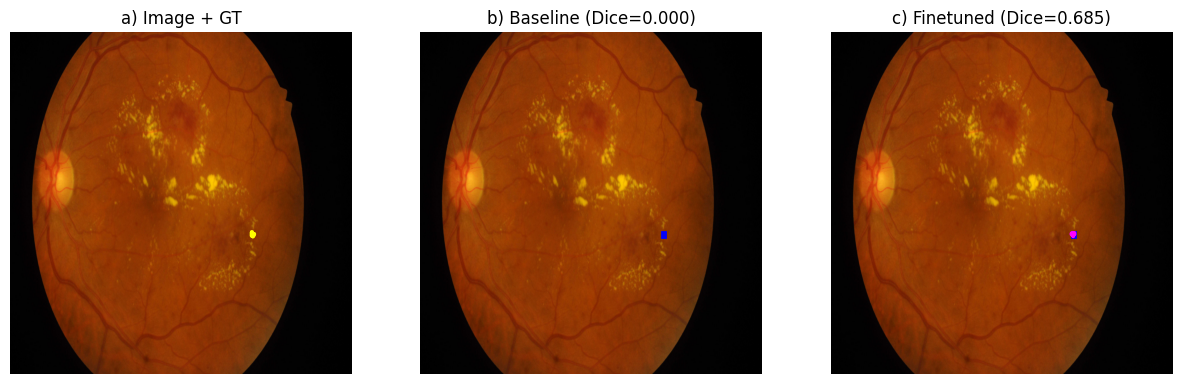

<Figure size 640x480 with 0 Axes>

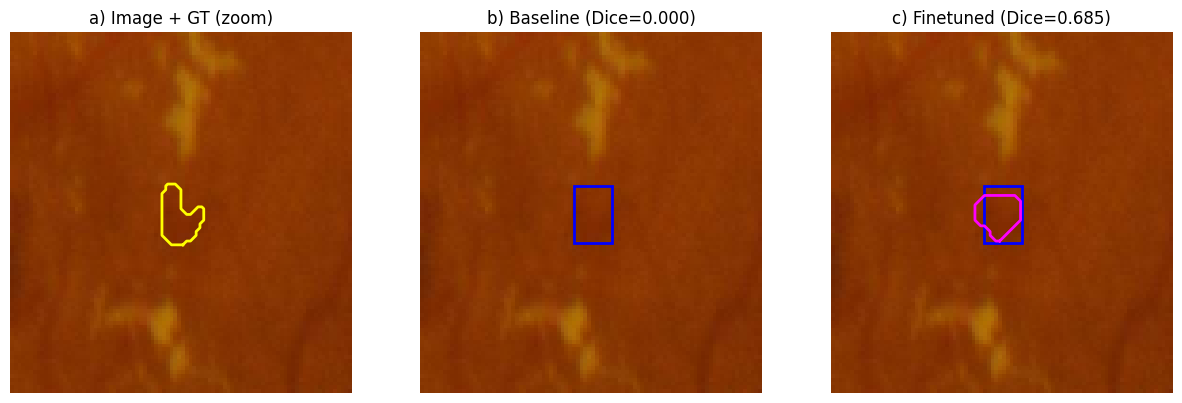

Finetuned pass complete and freed.


<Figure size 640x480 with 0 Axes>

In [7]:
finetuned = load_sam_finetuned(BASELINE_CKPT, FINETUNED_CKPT, device=DEVICE_DECODER)
print("Finetuned model loaded (encoder on CUDA with AMP; auto-fallback to CPU).")

pred_dir_f = Path(OUT_DIR) / "preds_finetuned"
pred_dir_f.mkdir(parents=True, exist_ok=True)

fig_counters = {s: 0 for s in PROMPT_STRATS}
#results={}
bar = tqdm(items, desc="Finetuned pass (GPU encode w/ AMP → CPU fallback)", leave=False)
for m in bar:
    img = np.load(m["img"]).astype(np.float32)
    gt  = (np.load(m["gt"]).astype(np.uint8) > 0).astype(np.uint8)
    case_id = Path(m["img"]).stem

    embed_cpu = encode_image_auto(finetuned, img, device=DEVICE_DECODER, use_amp=True)

    for strat in PROMPT_STRATS:
        box_np, points_tuple = make_prompt_from_gt(gt, strat)

        pred_f, _ = predict_with_cached_embed(
            finetuned, embed_cpu, box_np, points_tuple,
            device=DEVICE_DECODER, thresh=0.5, use_amp=True
        )

        out_np = pred_dir_f / strat / f"{case_id}.npy"
        out_np.parent.mkdir(parents=True, exist_ok=True)
        np.save(out_np, pred_f)

        metrics_f = compute_metrics(gt, pred_f)

        pred_b_path = Path(OUT_DIR) / "preds_baseline" / strat / f"{case_id}.npy"
        pred_b = np.load(pred_b_path) if pred_b_path.exists() else np.zeros_like(pred_f, dtype=np.uint8)

        key = (case_id, strat)
        results.setdefault(key, {})
        results[key].update({
            "dice_finetuned": metrics_f["dice"],
            "iou_finetuned": metrics_f["iou"],
            "precision_finetuned": metrics_f["precision"],
            "recall_finetuned": metrics_f["recall"],
        })

        # capped figures per prompt
        if fig_counters[strat] < FIGS_PER_STRAT and strat=='box':
            fig_dir = Path(OUT_DIR) / "figs" / strat
            fig_dir.mkdir(parents=True, exist_ok=True)
            fig_path = fig_dir / f"{case_id}_{strat}.png"
            plot_triptych(img, gt, pred_b, pred_f, box_np, points_tuple, str(fig_path),
                          dice_b=results[key].get("dice_baseline"),
                          #dice_b=0,
                          dice_f=results[key].get("dice_finetuned"))
            fig_path_zoom = fig_dir / f"{case_id}_{strat}_zoom.png"
            show_triptych_zoom(img, gt, pred_b, pred_f, box_np, points_tuple, str(fig_path_zoom),
                               dice_b=results[key].get("dice_baseline"),
                               dice_f=results[key].get("dice_finetuned"))
            fig_counters[strat] += 1

    del embed_cpu, img, gt
    clear_cuda()

del finetuned
clear_cuda()
print("Finetuned pass complete and freed.")


In [8]:
import pandas as pd

rows = []
for (case_id, strat), d in results.items():
    rows.append({
        "case": case_id,
        "prompt_strat": strat,
        "img": d.get("img",""),
        "gt": d.get("gt",""),
        "dice_baseline": d.get("dice_baseline", np.nan),
        "iou_baseline": d.get("iou_baseline", np.nan),
        "precision_baseline": d.get("precision_baseline", np.nan),
        "recall_baseline": d.get("recall_baseline", np.nan),
        "dice_finetuned": d.get("dice_finetuned", np.nan),
        "iou_finetuned": d.get("iou_finetuned", np.nan),
        "precision_finetuned": d.get("precision_finetuned", np.nan),
        "recall_finetuned": d.get("recall_finetuned", np.nan),
    })

df = pd.DataFrame(rows).sort_values(["prompt_strat","case"]).reset_index(drop=True)

per_case_csv = Path(OUT_DIR) / "metrics_per_case.csv"
df.to_csv(per_case_csv, index=False)
print(f"[OK] Wrote per-case metrics → {per_case_csv}")

metrics_cols_b = ["dice_baseline","iou_baseline","precision_baseline","recall_baseline"]
metrics_cols_f = ["dice_finetuned","iou_finetuned","precision_finetuned","recall_finetuned"]

means = []
for strat, g in df.groupby("prompt_strat"):
    mb = g[metrics_cols_b].astype(float).mean(numeric_only=True, skipna=True)
    mf = g[metrics_cols_f].astype(float).mean(numeric_only=True, skipna=True)
    row = {"prompt_strat": strat}
    for k,v in mb.items(): row[f"mean_{k}"] = float(v)
    for k,v in mf.items(): row[f"mean_{k}"] = float(v)
    means.append(row)

df_means = pd.DataFrame(means)
per_strat_csv = Path(OUT_DIR) / "metrics_per_prompt_mean.csv"
df_means.to_csv(per_strat_csv, index=False)
print(f"[OK] Wrote per-prompt means → {per_strat_csv}")


[OK] Wrote per-case metrics → runs/medsam_idrid_eval/metrics_per_case.csv
[OK] Wrote per-prompt means → runs/medsam_idrid_eval/metrics_per_prompt_mean.csv


In [9]:
df_means.head()

,prompt_strat,mean_dice_baseline,mean_iou_baseline,mean_precision_baseline,mean_recall_baseline,mean_dice_finetuned,mean_iou_finetuned,mean_precision_finetuned,mean_recall_finetuned
0,box,0.408093,0.301698,0.539396,0.373973,0.696689,0.545816,0.718100,0.703165
1,box+point1,0.490757,0.361333,0.548804,0.512004,0.696044,0.545387,0.700926,0.721010
2,points1neg4,0.004352,0.002537,0.005890,0.019017,0.435011,0.296632,0.515465,0.518679
3,points3,0.148772,0.095590,0.140217,0.488791,0.585373,0.429205,0.654933,0.612570
